---
title: SpatioTemporal Field - T2M - Stationary
subject: AEMET T2M
short_title: 2a - Inference Laplacian
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
# numpyro.set_host_device_count(4)
# num_chains = 5
numpyro.set_host_device_count(num_devices)

In [2]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray

from st_evt.utils import ExperimentPath
from omegaconf import OmegaConf

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [4]:
dataset_path = autoroot.root.joinpath("data/ml_ready/aemet/t2max_stations_bm_summer.zarr")

variable = "t2max"
covariate = "gmst"
spatial_dim_name = "station_id"

# LOAD DATA
with xr.open_dataset(dataset_path, engine="zarr") as f:
    ds_bm = f.load()
    ds_bm = ds_bm.where(ds_bm.red_feten_mask == 1, drop=True)

ds_bm

<xarray.Dataset> Size: 73kB
Dimensions:         (gmst: 59, station_id: 154)
Coordinates:
    alt             (station_id) float32 616B 32.0 118.0 71.0 ... 620.0 10.0
  * gmst            (gmst) float64 472B 0.2447 0.1987 0.1827 ... 1.173 1.139
    lat             (station_id) float32 616B 40.96 41.15 41.19 ... 28.49 28.13
    lon             (station_id) float32 616B 0.87 1.108 1.217 ... -16.32 -15.42
    red_feten_mask  (station_id) uint8 154B 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * station_id      (station_id) <U5 3kB '0002I' '0016B' ... 'C447B' 'C659T'
    station_name    (station_id) <U50 31kB 'vandellòs' ... 'las palmas de g.c...
    time            (gmst) int64 472B 1961 1962 1963 1964 ... 2017 2018 2019
Data variables:
    t2max           (gmst, station_id) float32 36kB 32.2 33.32 ... 35.3 25.41

In [5]:
y = ds_bm[variable].values.squeeze()
num_temporal, num_spatial = y.shape
y.shape

(59, 154)

### Hierarchical Parameterization

In [6]:
# initialize empirical values
empirical_loc = ds_bm[variable].mean().values.squeeze()
empirical_std = ds_bm[variable].std().values.squeeze()

print(f"Loc: {empirical_loc.squeeze():.2f}")
print(f"Scale: {empirical_std.squeeze():.2f}")

empirical_loc_log = np.log(empirical_loc)
empirical_std_log = np.log(empirical_std)

print(f"Loc (log): {empirical_loc_log:.2f}")
print(f"Scale (log): {empirical_std_log:.2f}")

Loc: 36.18
Scale: 4.07
Loc (log): 3.59
Scale (log): 1.40


## Model

In [7]:
from jaxtyping import Float, Array
import equinox as eqx
import numpyro
import numpyro.distributions as dist
from tensorflow_probability.substrates.jax import distributions as tfd
from st_evt._src.models.gevd import StationaryUnPooledGEVD
from st_evt._src.modules.models.aemet.gevd_stationary_iid.model import init_t2m_model
from loguru import logger


In [9]:
model = init_t2m_model(
    y_values=ds_bm[variable].values,
    spatial_dim_name=spatial_dim_name,
    time_dim_name=covariate,
    variable_name=variable,
    
)

2024-12-17 23:43:56.936 | DEBUG    | st_evt._src.modules.models.aemet.gevd_stationary_iid.model:init_t2m_model:75 - Initial Location: Normal(36.18, 4.07)
2024-12-17 23:43:56.936 | DEBUG    | st_evt._src.modules.models.aemet.gevd_stationary_iid.model:init_t2m_model:80 - Initial Scale: LogNormal(1.40, 0.5)


In [10]:
with numpyro.handlers.seed(rng_seed=123):
    y_sample = model(num_spatial=num_spatial, num_timesteps=num_temporal)



### Prior Predictions

In [11]:
import arviz as az

In [12]:
from numpyro.infer import Predictive

rng_key, rng_key_ = jrandom.split(rng_key)
prior_predictive = Predictive(model, num_samples=1_000)
prior_samples = prior_predictive(rng_key_)

In [13]:
az_ds_prior = az.from_numpyro(
    prior=prior_samples,
    dims=model.dimensions
    # pred_dims={"obs": ["time"]}
)

In [14]:
az_ds_prior

Inference data with groups:
	> prior

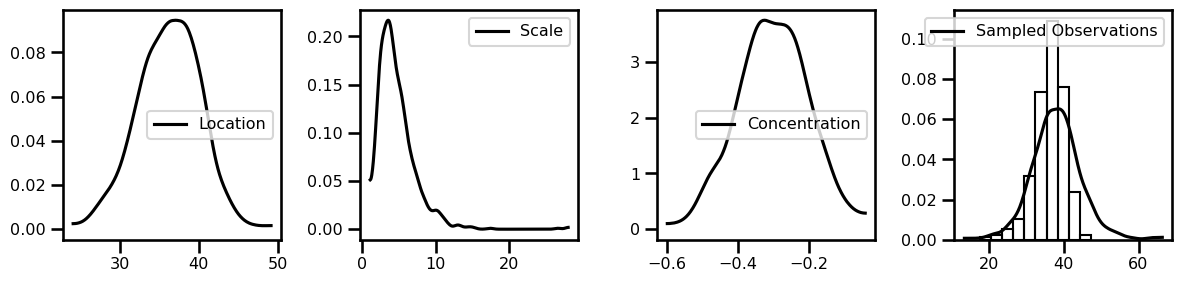

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))

az.plot_dist(prior_samples["location"], kind="kde", color="black", label="Location", ax=ax[0])
az.plot_dist(prior_samples["scale"], kind="kde", color="black", label="Scale", ax=ax[1])
az.plot_dist(prior_samples["concentration"], kind="kde", color="black", label="Concentration", ax=ax[2])
az.plot_dist(prior_samples[variable], kind="kde", color="black", label="Sampled Observations", ax=ax[3], plot_kwargs=dict(zorder=3))
# az.plot_dist(y.ravel(), kind="hist", color="black", label="Observations", ax=ax[3], plot_kwargs=dict(zorder=3))
ax[3].hist(y.ravel(), density=True, bins=10, fill=False, label="Observations")

# fig.savefig(figures_path.joinpath("density_prior.png"))

fig.set(
    dpi=100,
    size_inches=(12,3)
)

plt.tight_layout()
plt.show()

## Inference

In this example, we will use MCMC. We only have 3 parameters so this will be relatively quick.

In [18]:
from st_evt._src.models.inference import SVILearner, MCMCLearner

In [19]:
num_steps = 200_000

init_lr = 1e-10
peak_lr = 1e-3
end_lr = 1e-4
method = "laplace"
svi_learner = SVILearner(model, peak_lr=peak_lr, end_lr=end_lr, init_lr=init_lr, num_steps=num_steps, method=method)

svi_posterior = svi_learner(y=y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [01:49<00:00, 1823.47it/s, init loss: 27028.1797, avg. loss [190001-200000]: 18571.3027]


In [20]:
# grab median params
init_params = svi_posterior.median_params

## Posterior

In [21]:
num_posterior_samples = 1_000

# POSTERIOR
logger.info("Calculating Posterior Samples...")
rng_key, rng_subkey = jrandom.split(rng_key)
posterior_samples = svi_posterior.variational_samples(rng_subkey, num_samples=num_posterior_samples)

# PREDICTIVE POSTERIOR
logger.info("Calculating Posterior Samples for Log-Likelihood...")
return_sites = ["location", "scale", "concentration", variable]
posterior_predictive_samples = svi_posterior.posterior_predictive_samples(rng_subkey, num_samples=num_posterior_samples, return_sites=return_sites, num_timesteps=y.shape[0])

# LOG LIKELIHOOD
logger.info("Calculating Log-Likelihood...")
nll = svi_posterior.log_likelihood_samples(rng_subkey, num_samples=num_posterior_samples, y=y)

2024-12-17 23:46:25.899 | INFO     | __main__:<module>:4 - Calculating Posterior Samples...
2024-12-17 23:46:30.612 | INFO     | __main__:<module>:9 - Calculating Posterior Samples for Log-Likelihood...
2024-12-17 23:46:31.117 | INFO     | __main__:<module>:14 - Calculating Log-Likelihood...


In [22]:
logger.info("Constructing Posterior Data Structure")
az_ds = az.from_dict(
    posterior={k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
    posterior_predictive={k: np.expand_dims(v, 0) for k, v in posterior_predictive_samples.items()},
    log_likelihood={k: np.expand_dims(v, 0) for k, v in nll.items()},
    observed_data={variable: y},
    dims=model.dimensions,
)

# correct coordinates
logger.info("Constructing Posterior Data Structure")
az_ds = az_ds.assign_coords({covariate: ds_bm[covariate]})
az_ds = az_ds.assign_coords({spatial_dim_name: ds_bm[spatial_dim_name]})

logger.info("Adding Coordinates...")
az_ds.posterior_predictive["nll"] = az_ds.log_likelihood[variable]
az_ds.posterior_predictive[f"{variable}_true"] = az_ds.observed_data[variable]

# fix some log likelihood stats
logger.info("Fixing Log-Likelihood Stats...")
nll = az_ds.log_likelihood[variable]
az_ds.log_likelihood[variable] = nll.where(np.isfinite(nll), np.finfo(float).eps)
nll = az_ds.posterior_predictive["nll"]
az_ds.posterior_predictive["nll"] = nll.where(np.isfinite(nll), np.finfo(float).eps)

az_ds

2024-12-17 23:46:32.479 | INFO     | __main__:<module>:1 - Constructing Posterior Data Structure
2024-12-17 23:46:32.489 | INFO     | __main__:<module>:11 - Constructing Posterior Data Structure
2024-12-17 23:46:32.522 | INFO     | __main__:<module>:15 - Adding Coordinates...
2024-12-17 23:46:32.524 | INFO     | __main__:<module>:20 - Fixing Log-Likelihood Stats...


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

### Predictions

In [23]:
# PREDICTIONS
return_sites = ["location", "scale", "concentration", variable]
prediction_samples = svi_posterior.posterior_predictive_samples(rng_subkey, num_samples=num_posterior_samples, return_sites=return_sites, num_timesteps=y.shape[0])

In [24]:
logger.info("Constructing Posterior")
az_ds_pred = az.from_dict(
    predictions={k: np.expand_dims(v, 0) for k, v in prediction_samples.items()},
    pred_dims=model.dimensions,
)

# correct coordinates
az_ds_pred = az_ds_pred.assign_coords({covariate: ds_bm[covariate]})
az_ds_pred = az_ds_pred.assign_coords({spatial_dim_name: ds_bm[spatial_dim_name]})
az_ds_pred

2024-12-17 23:46:38.998 | INFO     | __main__:<module>:1 - Constructing Posterior


Inference data with groups:
	> predictions

In [25]:
az_ds.add_groups(az_ds_pred)
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> observed_data

#### MCMC Statistics

In [26]:
stats = az.waic(az_ds)
stats

/home/juanjohn/miniconda/envs/stevt/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 1000 posterior samples and 9086 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -18200.89    75.68
p_waic      623.71        -

There has been a warning during the calculation. Please check the results.

In [27]:

az_ds.log_likelihood.attrs["elpd_waic"] = stats.elpd_waic
az_ds.log_likelihood.attrs["se"] = stats.se
az_ds.log_likelihood.attrs["p_waic"] = stats.p_waic

### Save Data

In [28]:
mcmc_results_path = Path("/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/aemet/t2max/stationary_iid_lap_redfeten/results")
mcmc_results_path.mkdir(parents=True, exist_ok=True)
mcmc_results_path = mcmc_results_path.joinpath("stationary_iid_lap_redfeten.zarr")
az_ds.to_zarr(store=str(mcmc_results_path))

<zarr.hierarchy.Group '/'>